In [1]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback
from itertools import chain
import numpy as np
import pandas as pd

import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
def get_sentences(data_list):
    sentences = []
    for a in data_list.article.unique():
        words = []
        prev_n = 0
        for _,s in data_list.loc[data_list.article == a].iterrows():
            n = s['sentence_no']
            if n != prev_n:
                if len(words) > 2 and len(set([x[1] for x in words])) > 1:
                    sentences.append(words)
                words = []
            words.append((s['word'], s['encoding'], s['part_of_speech']))
            prev_n = n
            
        if len(words) > 2 and len(set([x[1] for x in words])) > 1:
            sentences.append(words)
            
    return sentences

In [3]:
data_list = pd.read_csv('../data/go/go_cc3.csv')
data_list.word.fillna('NA', inplace=True)

# temp = pd.read_csv('../data/go_bpmf_2.0_more.csv')
# temp.word.fillna('NA', inplace=True)

# data_list = data_list.merge(temp, on=['article', 'sentence_no', 'word_no'])
# data_list.sort_values(['article', 'sentence_no'], kind='mergesort', inplace=True)
# x_counts = data_list.encoding_x.value_counts()
# y_counts = data_list.encoding_y.value_counts()
# data_list['encoding_x'] = data_list.encoding_x.apply(lambda x: x if x_counts[x] > 4 else 'O')
# data_list['encoding_y'] = data_list.encoding_y.apply(lambda x: x if y_counts[x] > 4 else 'O')
# data_list['encoding'] = [i if i != 'O' else j for i,j in zip(data_list.encoding_x, data_list.encoding_y)]
# data_list = data_list.rename(columns={'word_x' : 'word'})

In [4]:
data_list = get_sentences(data_list)
print(data_list[0])
print(len(data_list))

words = list(set(y[0] for x in data_list for y in x))
n_words = len(words)
print(n_words)

tags = list(set(y[1] for x in data_list for y in x))
n_tags = len(tags)
print(n_tags)

poss = list(set(y[2] for x in data_list for y in x))
n_poss = len(poss)
print(n_poss)

[('CAF-1', 'GO:0033186', 'NNP'), ('Is', 'O', 'VBZ'), ('Essential', 'O', 'NNP'), ('for', 'O', 'IN'), ('Heterochromatin', 'GO:0000792', 'NNP'), ('Organization', 'O', 'NNP'), ('in', 'O', 'IN'), ('Pluripotent', 'O', 'NNP'), ('Embryonic', 'O', 'NNP'), ('Cells', 'O', 'NNP')]
2598
8890
456
43


In [5]:
max_len = 75
max_len_char = 10

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["O"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["O"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

pos2idx = {w: i+1 for i, w in enumerate(poss)}
pos2idx["X"] = 0
idx2pos = {i: w for w, i in pos2idx.items()}

In [6]:
print(tag2idx)

{'2_GO:0014069': 1, '2_GO:0042611': 2, 'GO:0014069': 213, 'GO:0097373': 174, '3_GO:0043025': 3, '3_GO:0031045': 4, 'GO:0031982': 214, '2_GO:0048471': 75, 'GO:0005776': 5, 'GO:0005874': 216, '1_GO:0042613': 6, 'GO:0005764': 7, '2_GO:0042101': 8, '1_GO:0005960': 217, 'GO:0005634': 9, '2_GO:0033186': 10, '4_GO:0043025': 218, 'GO:0005801': 219, '1_GO:0042555': 220, '1_GO:0005911': 78, '2_GO:0005714': 11, '4_GO:0016605': 223, 'GO:0031225': 225, 'GO:0030849': 13, '1_GO:0001750': 226, '2_GO:0031519': 14, '2_GO:0043227': 15, '2_GO:0031965': 227, '3_GO:0035102': 228, '1_GO:0000805': 229, '2_GO:0009898': 16, '3_GO:0005741': 231, '2_GO:0008021': 232, '4_GO:0044853': 233, '1_GO:0060076': 17, '1_GO:0048770': 18, 'GO:0005656': 421, 'GO:0005912': 19, '1_GO:0019867': 234, '3_GO:0000790': 235, '2_GO:0060076': 20, '2_GO:0042555': 21, '2_GO:0005770': 236, 'GO:0016020': 237, '2_GO:0016605': 22, '1_GO:0033186': 224, '3_GO:0032391': 23, '3_GO:0005675': 24, '2_GO:0045251': 238, 'GO:0048180': 239, '1_GO:00452

In [7]:
print(pos2idx)

{'FW': 1, 'CC': 2, 'JJR': 3, 'RB': 4, 'VBP': 5, 'IN': 6, 'JJS': 7, 'CD': 8, 'JJ': 9, 'NNS': 10, 'PDT': 11, 'WP$': 12, 'NN': 13, 'NNP': 14, '(': 36, '``': 20, 'RBS': 15, 'VBD': 16, 'WDT': 17, '.': 18, 'NNPS': 19, 'PRP': 21, 'WP': 22, 'VBZ': 23, 'EX': 25, "''": 27, 'VBG': 26, 'WRB': 28, 'RP': 29, ')': 30, 'PRP$': 31, 'VB': 33, '#': 34, 'UH': 35, ':': 38, 'RBR': 39, 'X': 0, '$': 40, 'TO': 32, 'VBN': 24, 'DT': 37, 'POS': 41, ',': 42, 'MD': 43}


In [8]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in data_list]

In [9]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["O"], padding='post', truncating='post')

In [10]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

111


In [11]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["O"] = 0

In [29]:
X_word = [[w[0] for w in s] for s in data_list]
new_X = []
for seq in X_word:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("ENDPAD")
    new_X.append(new_seq)
X_word = new_X

In [30]:
X_char = []
for sentence in data_list:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("O"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [31]:
X_pos = [[pos2idx[w[2]] for w in s] for s in data_list]
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, value=pos2idx["X"], padding='post', truncating='post')

In [32]:
y = [[tag2idx[w[1]] for w in s] for s in data_list]
y = pad_sequences(maxlen=max_len, sequences=y,value=tag2idx["O"], padding='post', truncating='post')

In [33]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags+1) for i in y]

In [34]:
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.3, random_state=2018)
X_pos_tr, X_pos_te, _, _ = train_test_split(X_pos, y, test_size=0.3, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.3, random_state=2018)

In [35]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
sess = tf.Session()
K.set_session(sess)
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(32*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [36]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D, Flatten,Lambda
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

# input and embedding for words
word_in = Input(shape=(max_len,), dtype=tf.string)

emb_word = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(word_in)

# input and embedding for parts of speech
pos_in = Input(shape=(max_len,))
emb_pos = Embedding(input_dim=n_poss + 1, output_dim=len(pos2idx),
                     input_length=max_len, mask_zero=True)(pos_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=100,
                           input_length=max_len_char, mask_zero=True))(char_in)


dropout = Dropout(0.3)(emb_char)

char_enc = TimeDistributed(LSTM(units=150, return_sequences=False,
                                recurrent_dropout=0.5))(dropout)

# main GRU
x = concatenate([emb_word, char_enc, emb_pos])
main_lstm = Bidirectional(LSTM(units=200, return_sequences=True,
                             dropout=0.5,
                               recurrent_dropout=0.25))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_lstm)

model = Model([word_in, pos_in, char_in], out)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [37]:
from keras.optimizers import RMSprop

rmsopt = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=rmsopt, loss="categorical_crossentropy", metrics=["acc"])

In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 75, 10)       0                                            
__________________________________________________________________________________________________
time_distributed_7 (TimeDistrib (None, 75, 10, 100)  11300       input_9[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 75, 10, 100)  0           time_distributed_7[0][0]         
__________________________________________________________________________________________________
input_8 (I

In [39]:
from keras.utils import plot_model
plot_model(model, to_file='../data/output/graphs/LSTM-Elmo.png')

In [41]:
# history = model.fit([X_word_tr,
#                      np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
#                     np.array(y_tr).reshape(len(y_tr), max_len, 1),
#                     batch_size=32, epochs=15, validation_data=([X_word_te,
#                      np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))],
#                     np.array(y_te).reshape(len(y_te), max_len, 1)),
#                     verbose=1)
history = model.fit([X_word_tr[:len(X_word_tr)//32*32], X_pos_tr[:len(X_word_tr)//32*32],
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))[:len(X_word_tr)//32*32]],
                    np.array(y_tr[:len(X_word_tr)//32*32]),
                    batch_size=32, epochs=15, validation_data=([X_word_te[:len(y_te)//32*32], X_pos_te[:len(y_te)//32*32],
                     np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))[:len(y_te)//32*32]],
                    np.array(y_te[:len(y_te)//32*32])),
                    verbose=1)

Train on 1792 samples, validate on 768 samples
Epoch 1/15
1792/1792 [==============================] - 587s 328ms/step - loss: 0.5336 - acc: 0.9271 - val_loss: 0.3124 - val_acc: 0.9507
Epoch 2/15
1792/1792 [==============================] - 577s 322ms/step - loss: 0.2670 - acc: 0.9579 - val_loss: 0.2520 - val_acc: 0.9607
Epoch 3/15
1792/1792 [==============================] - 579s 323ms/step - loss: 0.1993 - acc: 0.9673 - val_loss: 0.2043 - val_acc: 0.9688
Epoch 4/15
1792/1792 [==============================] - 579s 323ms/step - loss: 0.1594 - acc: 0.9731 - val_loss: 0.2058 - val_acc: 0.9685
Epoch 5/15
1792/1792 [==============================] - 581s 324ms/step - loss: 0.1301 - acc: 0.9778 - val_loss: 0.1523 - val_acc: 0.9779
Epoch 6/15
1792/1792 [==============================] - 580s 324ms/step - loss: 0.1074 - acc: 0.9805 - val_loss: 0.1384 - val_acc: 0.9802
Epoch 7/15
1792/1792 [==============================] - 579s 323ms/step - loss: 0.0891 - acc: 0.9828 - val_loss: 0.1297 - val

In [44]:
hist = pd.DataFrame(history.history)
hist.to_csv('../data/results/performance/GO_LSTM-Elmo.tsv', sep='\t')

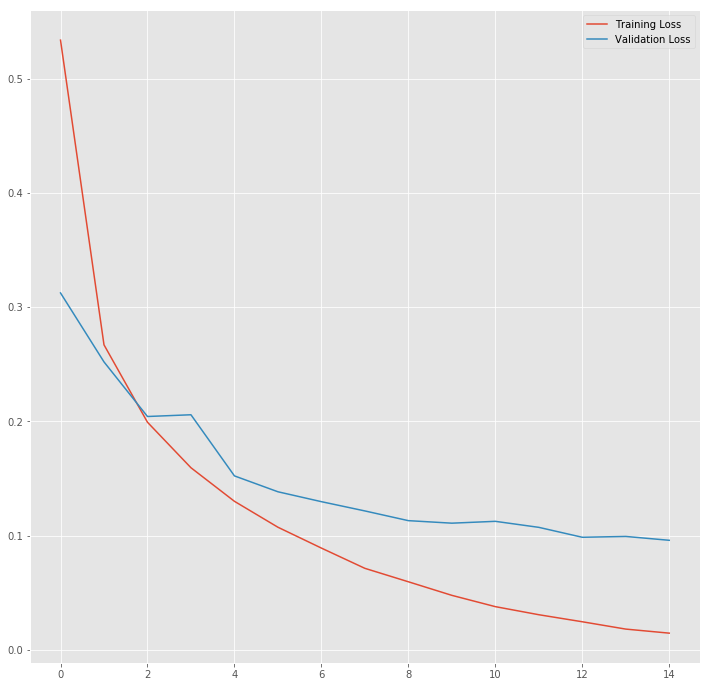

In [45]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend()
plt.show()

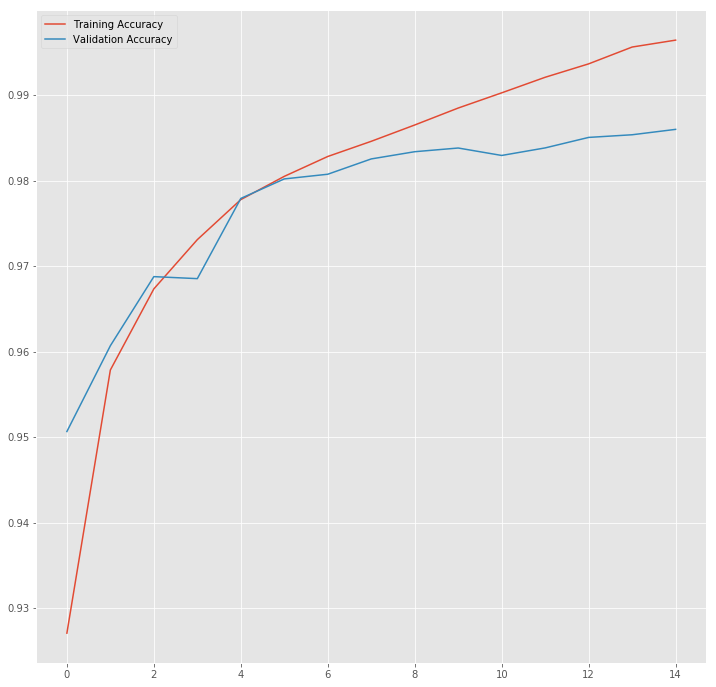

In [46]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"], label='Training Accuracy')
plt.plot(hist["val_acc"], label='Validation Accuracy')
plt.legend()
plt.show()

In [48]:
from sklearn.metrics import classification_report

predicted = model.predict([X_word_te[:len(y_te)//32*32], X_pos_te[:len(y_te)//32*32],
                        np.array(X_char_te[:len(y_te)//32*32]).reshape((len(X_char_te[:len(y_te)//32*32]),
                                                     max_len, max_len_char))])
true = []
predicted_val = []
word = []
for i in range(len(predicted)):
    p_tmp = np.argmax(predicted[i], axis=-1)
    t_tmp = np.argmax(y_te[i], -1)
    word.append(X_word_te[i])
    predicted_val.append(p_tmp)
    true.append(t_tmp)

wd = [list(map(lambda x: y, y)) for y in word]    
p = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val]
t = [list(map(lambda x: idx2tag[x], y)) for y in true]

report = classification_report(list(itertools.chain.from_iterable(t)), 
                                    list(itertools.chain.from_iterable(p)))
# print "\n"
print(report)

              precision    recall  f1-score   support

1_GO:0000790       0.00      0.00      0.00         1
1_GO:0000795       1.00      1.00      1.00         4
1_GO:0000800       0.00      0.00      0.00         1
1_GO:0000802       0.00      0.00      0.00         0
1_GO:0000803       1.00      0.67      0.80         3
1_GO:0000805       0.80      1.00      0.89         8
1_GO:0000806       1.00      1.00      1.00         2
1_GO:0001739       0.64      1.00      0.78         9
1_GO:0001741       0.92      1.00      0.96        22
1_GO:0001750       0.92      0.92      0.92        24
1_GO:0001917       0.70      1.00      0.82         7
1_GO:0005615       0.00      0.00      0.00         1
1_GO:0005634       1.00      1.00      1.00         8
1_GO:0005643       0.00      0.00      0.00         1
1_GO:0005657       0.33      0.50      0.40         2
1_GO:0005667       1.00      1.00      1.00         1
1_GO:0005675       1.00      1.00      1.00         2
1_GO:0005714       0.00    

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [50]:
import pandas as pd

df = pd.DataFrame(
{
    'Predicted' : list(itertools.chain.from_iterable(p)),
    'Ground Truth': list(itertools.chain.from_iterable(t)),
    'Word' : list(itertools.chain.from_iterable(wd)),
}
)


In [51]:
df = df[df['Word'] != 'O']

In [52]:
df1 = df[(df['Predicted'] != 'O') & (df['Ground Truth'] != 'O') | 
         (df['Predicted'] == 'O') & (df['Ground Truth'] != 'O') |
         (df['Predicted'] != 'O') & (df['Ground Truth'] == 'O')
        ]

report = classification_report(df1['Ground Truth'], 
                                    df1['Predicted'])
print("\n")
print(report)



              precision    recall  f1-score   support

1_GO:0000790       0.00      0.00      0.00         1
1_GO:0000795       1.00      1.00      1.00         4
1_GO:0000800       0.00      0.00      0.00         1
1_GO:0000802       0.00      0.00      0.00         0
1_GO:0000803       1.00      0.67      0.80         3
1_GO:0000805       0.80      1.00      0.89         8
1_GO:0000806       1.00      1.00      1.00         2
1_GO:0001739       0.64      1.00      0.78         9
1_GO:0001741       0.92      1.00      0.96        22
1_GO:0001750       0.92      0.92      0.92        24
1_GO:0001917       0.70      1.00      0.82         7
1_GO:0005615       0.00      0.00      0.00         1
1_GO:0005634       1.00      1.00      1.00         8
1_GO:0005643       0.00      0.00      0.00         1
1_GO:0005657       0.33      0.50      0.40         2
1_GO:0005667       1.00      1.00      1.00         1
1_GO:0005675       1.00      1.00      1.00         2
1_GO:0005714       0.00  

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [ ]:
# df.to_csv('../data/results/GO_merged_CHAR_LSTM_Based_CRF.tsv', sep='\t')

In [ ]:
# !python ./Go_Deep/src/accuracy/src/computeSim.py ../data/results/GO_merged_CHAR_LSTM_Based_CRF.tsv ../data/validation_data/GO_AllSubsumers.tsv 
#%run ./Go_Deep/src/accuracy/src/computeSim.py ../data/results/GO_merged_CHAR_LSTM_Based_CRF.tsv ../data/validation_data/GO_AllSubsumers.tsv 